In [789]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from joblib import dump,load
from functools import partial

pd.options.mode.chained_assignment = None

Klasa do przetwarzania danych - będzie sukcesywnie rozbudowywana - tutaj też nic nie ruszamy!

In [790]:
class DataPreprocessing:
   
            
    def __init__(self,DIR,file,quant=0,period=3):
        
        
        names=['D','P','V','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','DW']
        days=[1,2,3,4,5]
        std_range=[0.0,0.5,1.0,1,5]
        self.window=50
        self.m={}
        self.p={}
        self.Y=[\
        'Y_1_0.0','Y_2_0.0','Y_3_0.0','Y_4_0.0','Y_5_0.0',\
        'Y_1_0.5','Y_2_0.5','Y_3_0.5','Y_4_0.5','Y_5_0.5',\
        'Y_1_1.0','Y_2_1.0','Y_3_1.0','Y_4_1.0','Y_5_1.0',\
        'Y_1_1.5','Y_2_1.5','Y_3_1.5','Y_4_1.5','Y_5_1.5',\
        ]
        
        
        df = pd.read_csv(DIR+file, names=names)
        df=df.iloc[1:,:]
        df=df.sort_values(by='D',ascending=False)
        
        df['P']=df['P'].astype(float)
        df['V']=df['V'].astype(float)
        df['T1']=df['T1'].astype(float)
        df['T2']=df['T2'].astype(float)
        df['T3']=df['T3'].astype(float)
        df['T4']=df['T4'].astype(float)
        df['T5']=df['T5'].astype(float)
        df['T6']=df['T6'].astype(float)
        df['T7']=df['T7'].astype(float)
        df['T8']=df['T8'].astype(float)
        df['T9']=df['T9'].astype(float)
        df['T10']=df['T10'].astype(float)
        df['T11']=df['T11'].astype(float)
        df['DW']=df['DW'].astype(float)
        
        self.df=df
        df=self.prepare_table()
        
        df['%P']=df['P'].pct_change(periods=-1)*100
       
        
        df['%R_P_1']=-round((df['P'].pct_change(periods=1))*100,2)
        df['%R_P_2']=-round((df['P'].pct_change(periods=2))*100,2)
        df['%R_P_3']=-round((df['P'].pct_change(periods=3))*100,2)
        df['%R_P_4']=-round((df['P'].pct_change(periods=4))*100,2)
        df['%R_P_5']=-round((df['P'].pct_change(periods=5))*100,2)
        
        #clipping
        df['%P']=df['%P'].clip(-10,10)
       
        
        df['%R_P_1']=df['%R_P_1'].clip(-20,20)
        df['%R_P_2']=df['%R_P_2'].clip(-20,20)
        df['%R_P_3']=df['%R_P_3'].clip(-20,20)
        df['%R_P_4']=df['%R_P_4'].clip(-20,20)
        df['%R_P_5']=df['%R_P_5'].clip(-20,20)
        
        #quantizing 
        if quant>0:
            df['%P']=round(df['%P']*quant)/quant
            
            df['%R_P_1']=round(df['%R_P_1']*quant)/quant
            df['%R_P_2']=round(df['%R_P_2']*quant)/quant
            df['%R_P_3']=round(df['%R_P_3']*quant)/quant
            df['%R_P_4']=round(df['%R_P_4']*quant)/quant
            df['%R_P_5']=round(df['%R_P_5']*quant)/quant
            
       
        
        df=df.dropna()
        df=df.reset_index(drop=True)   
        self.df=df
        df=self.Y_labels()
        
        #df['Y']=df['%R_P_3'].apply(p_map_to_Y)
        self.DIR=DIR
        self.file=file
        self.df=df
        self.copy_df=self.df.copy()
        
    def prepare_table(self,days=[1,2,3,4,5],std_range=[0.0,0.5,1.0,1.5]):
        for d in days:
            self.df['%R_P_'+str(d)]=0
            self.df['%R_Min_'+str(d)]=0
            self.df['%R_Max_'+str(d)]=0
            for std in std_range:
                self.df['Y_'+str(d)+'_'+str(std)]=0
        self.df=self.df[['D','P','DW']+self.Y+\
                ['%R_P_1','%R_P_2','%R_P_3','%R_P_4','%R_P_5',\
                '%R_Min_1','%R_Max_1','%R_Min_2','%R_Max_2','%R_Min_3',\
                '%R_Max_3','%R_Min_4','%R_Max_4','%R_Min_5','%R_Max_5',\
                'T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11']]
        
        return self.df
        
    
    def Y_labels(self,days=[1,2,3,4,5],std_range=[0.0,0.5,1.0,1.5]):
        self.m={}
        self.p={}
        for d in days:
            if d==1:
                self.df['%R_Max_'+str(d)]=self.df['%R_P_1']
                self.df['%R_Min_'+str(d)]=self.df['%R_P_1']
            else:
                self.df['%R_Max_'+str(d)]=(self.df[['%R_Max_'+str(d-1),'%R_P_'+str(d)]]).max(axis=1)
                self.df['%R_Min_'+str(d)]=(self.df[['%R_Min_'+str(d-1),'%R_P_'+str(d)]]).min(axis=1)
        
        for d in days:
            for st in std_range:
                m_std=-self.df['%R_Min_'+str(d)][self.df['%R_Min_'+str(d)]<0].std()*st
                m_mean=self.df['%R_Min_'+str(d)][self.df['%R_Min_'+str(d)]<0].mean()
                m_count=self.df['%R_Min_'+str(d)][self.df['%R_Min_'+str(d)]<m_std+m_mean].count()

                p_std=self.df['%R_Max_'+str(d)][self.df['%R_Max_'+str(d)]>0].std()*st
                p_mean=self.df['%R_Max_'+str(d)][self.df['%R_Max_'+str(d)]>0].mean()
                p_count=self.df['%R_Max_'+str(d)][self.df['%R_Max_'+str(d)]>p_std+p_mean].count()

                self.df['Y_'+str(d)+'_'+str(st)] = self.df.apply(\
                                    lambda x: self.map_to_Y(x['%R_Min_'+str(d)], x['%R_Max_'+str(d)],\
                                    m_std+m_mean,p_std+p_mean), axis=1)

                self.m[str(d)+'_'+str(st)]=((m_std,m_mean,m_count))
                self.p[str(d)+'_'+str(st)]=((p_std,p_mean,p_count))
        
        
        return self.df

    def shiftData(self,col=['%P'],num=100):
        for z in col:
            for y in range(1,num+1):
                self.df[z+'_'+str(y)]=self.df[z].shift(-y)
        return self.df
    
    def drop(self):
        self.df=self.df.dropna()
        self.df=self.df.reset_index(drop=True)
        return self.df
    
    def scalize(self,fro=1,to=10000,dumper=False):
        scaler=StandardScaler()       
        X = scaler.fit_transform(self.df.iloc[:,fro:to])
        if dumper:
            dump(scaler,self.DIR+self.file+'_scaler.joblib')
        return X
   
    def map_to_Y(self,x_min,x_max,thres_m=0,thres_p=0,which_thres=''):  
        
        #select threshold
        thres_m=abs(thres_m)
        if which_thres=='plus':
            thres_m=thres_p
        elif which_thres=='minus':
            thres_p=thres_m
            
        if x_max>thres_p and x_min<-thres_m:
            return 3
        if x_max>thres_p:
            return 2
        elif x_min<-thres_m:
            return 0
        else:
            return 1

   

Ładujemy dane i przygotwujemy pierwsze stałe

In [791]:
DIR='AI\\data\\'
file='dax_tt.csv'
dp_dax=DataPreprocessing(DIR,file,quant=0,period=1)
file='brent_tt.csv'
dp_brent=DataPreprocessing(DIR,file,quant=0,period=1)
file='nas_tt.csv'
dp_nasdaq=DataPreprocessing(DIR,file,quant=0,period=1)
file='gold_tt.csv'
dp_gold=DataPreprocessing(DIR,file,quant=0,period=1)


In [792]:
dp_dax.df

,D,P,DW,Y_1_0.0,Y_2_0.0,Y_3_0.0,Y_4_0.0,Y_5_0.0,Y_1_0.5,Y_2_0.5,...,T3,T4,T5,T6,T7,T8,T9,T10,T11,%P
0,2019-12-27,13337.11,4.0,1,1,1,1,1,1,1,...,1.0,3.0,3.0,2.0,2.0,-2.0,-2.0,-2.0,-2.0,0.271634
1,2019-12-23,13300.98,0.0,1,1,1,1,1,1,1,...,1.0,3.0,3.0,2.0,2.0,-2.0,-2.0,-2.0,-2.0,-0.134546
2,2019-12-20,13318.90,4.0,1,1,1,1,1,1,1,...,1.0,3.0,3.0,2.0,2.0,-2.0,-2.0,-2.0,-2.0,0.809418
3,2019-12-19,13211.96,3.0,1,1,1,1,1,1,1,...,1.0,3.0,3.0,2.0,2.0,-2.0,-1.0,-1.0,-1.0,-0.077143
4,2019-12-18,13222.16,2.0,1,1,1,1,1,1,1,...,1.0,3.0,3.0,2.0,2.0,2.0,2.0,-1.0,-1.0,-0.494212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,2011-05-09,7410.52,0.0,2,2,1,1,1,2,1,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-1.090861
2190,2011-05-06,7492.25,4.0,0,1,1,1,1,1,1,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1.562839
2191,2011-05-05,7376.96,3.0,2,2,2,2,1,2,1,...,-2.0,-2.0,-1.0,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0,0.041091
2192,2011-05-04,7373.93,2.0,1,2,2,2,1,1,1,...,-2.0,-2.0,-1.0,-3.0,-3.0,-3.0,-1.0,-1.0,-1.0,-1.690109


In [793]:
from scipy import stats
dp=dp_nasdaq
dp.df['%R_P_5'].kurtosis(),dp.df['%R_P_5'].skew(),stats.jarque_bera(dp.df['%R_P_5'])


(5.55732183686057, -1.0955336418690693, (4435.429943564402, 0.0))

In [794]:
gauss=pd.DataFrame(np.random.randn(1000))
gauss.kurtosis(),gauss.skew(),stats.jarque_bera(gauss)

(0   -0.130007
 dtype: float64, 0   -0.111663
 dtype: float64, (2.8351985310534613, 0.24229500519034064))

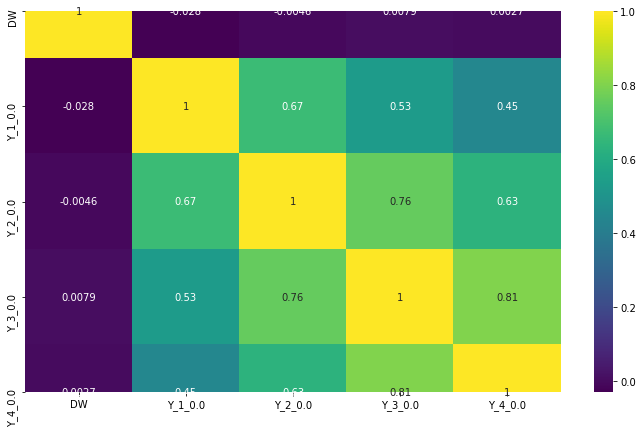

In [795]:



A=pd.concat([dp_nasdaq.df.iloc[:,2:7],dp_nasdaq.df.iloc[:,52:]],axis=1)
plt.figure(figsize=(12,7))
sns.heatmap(A.corr(),annot=True,cmap='viridis')

In [796]:
dp=dp_brent

dp.m,dp.p,dp.df['D'].count(),\
#dp.m[4][0]*dp.m[4][1]+dp.p[4][0]*dp.p[4][1]

({'1_0.0': (-0.0, -1.5615126436781637, 820),
  '1_0.5': (-0.7567122456088309, -1.5615126436781637, 480),
  '1_1.0': (-1.5134244912176618, -1.5615126436781637, 272),
  '1_1.5': (-2.2701367368264926, -1.5615126436781637, 163),
  '2_0.0': (-0.0, -2.1308302718589274, 1034),
  '2_0.5': (-1.0241278020010312, -2.1308302718589274, 608),
  '2_1.0': (-2.0482556040020623, -2.1308302718589274, 337),
  '2_1.5': (-3.0723834060030937, -2.1308302718589274, 201),
  '3_0.0': (-0.0, -2.6033077180086854, 1134),
  '3_0.5': (-1.2268446445595036, -2.6033077180086854, 662),
  '3_1.0': (-2.453689289119007, -2.6033077180086854, 381),
  '3_1.5': (-3.680533933678511, -2.6033077180086854, 232),
  '4_0.0': (-0.0, -3.019936487773893, 1184),
  '4_0.5': (-1.415056010316561, -3.019936487773893, 705),
  '4_1.0': (-2.830112020633122, -3.019936487773893, 416),
  '4_1.5': (-4.245168030949683, -3.019936487773893, 236),
  '5_0.0': (-0.0, -3.367162038449796, 1215),
  '5_0.5': (-1.5855850435480836, -3.367162038449796, 730),
  

In [797]:
dp_gold.shiftData(col=['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11'],num=100)
dp_brent.shiftData(col=['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11'],num=100)
dp_dax.shiftData(col=['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11'],num=100)
dp_nasdaq.shiftData(col=['T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11'],num=100)

dp_gold.drop(),dp_brent.drop(),dp_dax.drop(),dp_nasdaq.drop()

(               D        P   DW  Y_1_0.0  Y_2_0.0  Y_3_0.0  Y_4_0.0  Y_5_0.0  \
 0     2019-12-30  1517.85  0.0        1        1        1        1        2   
 1     2019-12-27  1517.65  4.0        1        1        1        1        1   
 2     2019-12-26  1507.55  3.0        1        1        1        1        1   
 3     2019-12-25  1504.40  2.0        1        1        1        1        1   
 4     2019-12-24  1492.75  1.0        1        1        2        2        2   
 ...          ...      ...  ...      ...      ...      ...      ...      ...   
 4387  2002-11-06   317.50  2.0        2        2        1        2        2   
 4388  2002-11-05   318.20  1.0        1        1        1        1        2   
 4389  2002-11-04   318.30  0.0        1        1        1        1        1   
 4390  2002-11-01   318.80  4.0        1        1        1        1        1   
 4391  2002-10-31   318.00  3.0        1        1        1        1        1   
 
       Y_1_0.5  Y_2_0.5  ...  T11_91  

In [798]:
dp_nasdaq.df.iloc[:,49:]

,%P,T1_1,T1_2,T1_3,T1_4,T1_5,T1_6,T1_7,T1_8,T1_9,...,T11_91,T11_92,T11_93,T11_94,T11_95,T11_96,T11_97,T11_98,T11_99,T11_100
0,-0.083501,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,0.905798,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,0.040248,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0
3,0.201878,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0
4,0.430491,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.0,-3.0,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,-2.784191,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,...,2.0,3.0,3.0,2.0,2.0,2.0,1.0,-3.0,-2.0,2.0
2890,2.427570,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,3.0,3.0,2.0,2.0,2.0,1.0,-3.0,-2.0,2.0,3.0
2891,0.582487,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,3.0,2.0,2.0,2.0,1.0,-3.0,-2.0,2.0,3.0,2.0
2892,0.011012,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,1.0,-3.0,-2.0,2.0,3.0,2.0,1.0


In [799]:
dp_gold.df['%R_P_3'].std(),dp_brent.df['%R_P_3'].std(),dp_dax.df['%R_P_3'].std(),dp_nasdaq.df['%R_P_3'].std()

(1.9592306631111405, 3.491238250615084, 1.9905853938585043, 2.156734273367002)

In [800]:
dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']<0].mean(),dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']>0].mean()

(-1.514697275479313, 1.4130955360867772)

In [801]:
m=(dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']<0].std()*.5,dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']<0].count())
p=(dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']>0].std()*.5,dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']>0].count())

In [802]:
dp_gold.df['%R_P_3'].where(dp_gold.df['%R_P_3']>0).std()

1.1723023647328328

In [803]:
m,p,m[0]*m[1],p[0]*p[1]

((0.7334268800881262, 1982),
 (0.5861511823664164, 2397),
 1453.6520763346662,
 1405.0043841323002)

In [804]:
ma=dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']>m[0]].count()
pa=dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']>p[0]].count()
al=dp_gold.df['%R_P_3'].count()
ma,m[0],pa,p[0],al,pa*p[0]-ma*m[0]

(1624, 0.7334268800881262, 1767, 0.5861511823664164, 4392, -155.35611402165932)

In [805]:
ma/m[1],pa/p[1]

(0.8193743693239153, 0.737171464330413)

In [806]:
X_brent=dp_brent.scalize(fro=49,dumper=True)
X_gold=dp_gold.scalize(fro=49,dumper=True)
X_dax=dp_dax.scalize(fro=49,dumper=True)
X_nasdaq=dp_nasdaq.scalize(fro=49,dumper=True)

In [807]:
X_brent=pd.DataFrame(X_brent)
X_gold=pd.DataFrame(X_gold)
X_dax=pd.DataFrame(X_dax)
X_nasdaq=pd.DataFrame(X_nasdaq)
X=pd.DataFrame()
X=X.append([X_brent,X_gold,X_nasdaq,X_dax])
X.mean(),X.std()

(0      -9.124237e-18
 1       1.887976e-15
 2      -2.074265e-15
 3      -7.555384e-16
 4      -1.604254e-15
             ...     
 1096    3.100306e-16
 1097    6.025221e-16
 1098    8.968674e-17
 1099   -4.022080e-16
 1100    5.026391e-17
 Length: 1101, dtype: float64, 0       1.000036
 1       1.000036
 2       1.000036
 3       1.000036
 4       1.000036
           ...   
 1096    1.000036
 1097    1.000036
 1098    1.000036
 1099    1.000036
 1100    1.000036
 Length: 1101, dtype: float64)

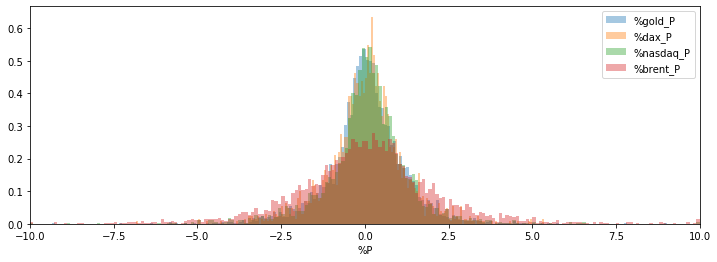

In [808]:
plt.figure(figsize=(12,4))
sns.distplot(dp_gold.df['%P'],kde=False,bins=200,label='%gold_P',norm_hist=True)
sns.distplot(dp_dax.df['%P'],kde=False,bins=200,label='%dax_P',norm_hist=True)
sns.distplot(dp_nasdaq.df['%P'],kde=False,bins=200,label='%nasdaq_P',norm_hist=True)
sns.distplot(dp_brent.df['%P'],kde=False,bins=200,label='%brent_P',norm_hist=True)
plt.xlim(-10,10)
plt.legend()

In [809]:
X_brent

,0,1,2,3,4,5,6,7,8,9,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,-0.724006,0.087834,0.088032,0.08823,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,-1.025136,-1.024902,-1.024902,-1.025364,-1.025827,-1.026287,-1.026750,-1.027213,-1.027632,-1.028052
1,0.362245,0.087834,0.088032,0.08823,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,-1.025136,-1.024902,-1.024902,-1.025364,-1.025827,-1.026287,-1.026750,-1.027213,-1.027632,-1.479913
2,0.178728,0.087834,0.088032,0.08823,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,-1.025136,-1.024902,-1.024902,-1.025364,-1.025827,-1.026287,-1.026750,-1.027213,-1.479445,-1.479913
3,0.519380,0.087834,0.088032,0.08823,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,-1.025136,-1.024902,-1.024902,-1.025364,-1.025827,-1.026287,-1.026750,-1.478977,-1.479445,-1.479913
4,0.364047,0.087834,0.088032,0.08823,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,-1.025136,-1.024902,-1.024902,-1.025364,-1.025827,-1.026287,-1.478491,-1.478977,-1.479445,-1.479913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,1.157432,-0.811799,-0.811534,-0.81127,-0.811005,-0.810740,-0.810476,-0.810211,-0.809947,-0.809682,...,0.330129,-1.476599,-1.476599,-1.025364,-1.025827,-1.478005,-1.026750,0.779843,0.779619,1.231256
4390,-1.260684,-0.811799,-0.811534,-0.81127,-0.811005,-0.810740,-0.810476,-0.810211,-0.809947,-0.809682,...,-1.476891,-1.476599,-1.024902,-1.025364,-1.477569,-1.026287,0.780215,0.779843,1.231431,0.779394
4391,0.408892,-0.811799,-0.811534,-0.81127,-0.811005,-0.810740,-0.810476,-0.810211,-0.809947,-0.809682,...,-1.476891,-1.024902,-1.024902,-1.477084,-1.025827,0.780586,0.780215,1.231607,0.779619,0.779394
4392,0.854112,-0.811799,-0.811534,-0.81127,-0.811005,-0.810740,-0.810476,-0.810211,-0.809947,-0.809682,...,-1.025136,-1.024902,-1.476599,-1.025364,0.781142,0.780586,1.231956,0.779843,0.779619,0.327533


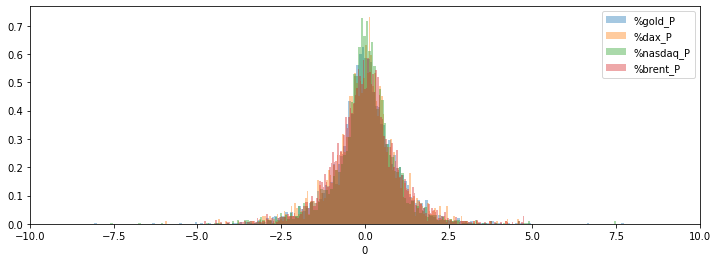

In [810]:
plt.figure(figsize=(12,4))
sns.distplot(X_gold[0],kde=False,bins=200,label='%gold_P',norm_hist=True)
sns.distplot(X_dax[0],kde=False,bins=200,label='%dax_P',norm_hist=True)
sns.distplot(X_nasdaq[0],kde=False,bins=200,label='%nasdaq_P',norm_hist=True)
sns.distplot(X_brent[0],kde=False,bins=200,label='%brent_P',norm_hist=True)
plt.xlim(-10,10)
plt.legend()

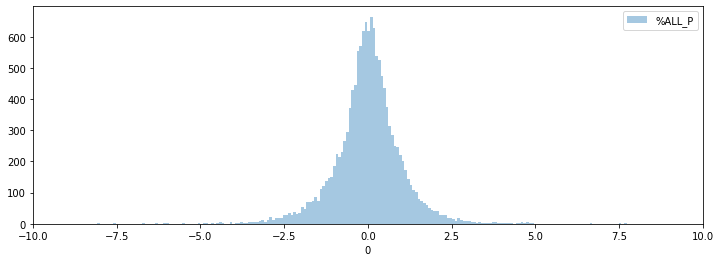

In [811]:
plt.figure(figsize=(12,4))
sns.distplot(X[0],kde=False,bins=200,label='%ALL_P')

plt.xlim(-10,10)
plt.legend()

In [812]:
dp_dax.Y

['Y_1_0.0',
 'Y_2_0.0',
 'Y_3_0.0',
 'Y_4_0.0',
 'Y_5_0.0',
 'Y_1_0.5',
 'Y_2_0.5',
 'Y_3_0.5',
 'Y_4_0.5',
 'Y_5_0.5',
 'Y_1_1.0',
 'Y_2_1.0',
 'Y_3_1.0',
 'Y_4_1.0',
 'Y_5_1.0',
 'Y_1_1.5',
 'Y_2_1.5',
 'Y_3_1.5',
 'Y_4_1.5',
 'Y_5_1.5']

In [813]:
dp_brent.df[dp_brent.Y]

,Y_1_0.0,Y_2_0.0,Y_3_0.0,Y_4_0.0,Y_5_0.0,Y_1_0.5,Y_2_0.5,Y_3_0.5,Y_4_0.5,Y_5_0.5,Y_1_1.0,Y_2_1.0,Y_3_1.0,Y_4_1.0,Y_5_1.0,Y_1_1.5,Y_2_1.5,Y_3_1.5,Y_4_1.5,Y_5_1.5
0,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1
1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4389,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4390,2,2,2,2,2,2,1,1,2,2,1,1,1,1,1,1,1,1,1,1
4391,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4392,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [814]:
Z_brent=pd.concat([X_brent,dp_brent.df[dp_brent.Y]],axis=1)
Z_gold=pd.concat([X_gold,dp_gold.df[dp_gold.Y]],axis=1)
Z_dax=pd.concat([X_dax,dp_dax.df[dp_dax.Y]],axis=1)
Z_nasdaq=pd.concat([X_nasdaq,dp_nasdaq.df[dp_nasdaq.Y]],axis=1)
Z=pd.DataFrame()
Z=Z.append([Z_brent,Z_gold,Z_nasdaq,Z_dax])


In [815]:
Z_dax

,0,1,2,3,4,5,6,7,8,9,...,Y_1_1.0,Y_2_1.0,Y_3_1.0,Y_4_1.0,Y_5_1.0,Y_1_1.5,Y_2_1.5,Y_3_1.5,Y_4_1.5,Y_5_1.5
0,0.192711,-0.679528,-0.678058,-0.676593,-0.666261,-0.656235,-0.642401,-0.629150,-0.620188,-0.611462,...,1,1,1,1,1,1,1,1,1,1
1,-0.159960,-0.679528,-0.678058,-0.676593,-0.666261,-0.656235,-0.642401,-0.629150,-0.620188,-0.611462,...,1,1,1,1,1,1,1,1,1,1
2,0.659650,-0.679528,-0.678058,-0.676593,-0.666261,-0.656235,-0.642401,-0.629150,-0.620188,-0.611462,...,1,1,1,1,1,1,1,1,1,1
3,-0.110119,-0.679528,-0.678058,-0.676593,-0.666261,-0.656235,-0.642401,-0.629150,-0.620188,-0.611462,...,1,1,1,1,1,1,1,1,1,1
4,-0.472245,-0.679528,-0.678058,-0.676593,-0.666261,-0.656235,-0.642401,-0.629150,-0.620188,-0.611462,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,2.446418,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-6.430805,-6.366077,...,2,2,2,2,2,2,2,2,2,2
2090,0.500765,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-6.497483,-6.430805,-7.804731,...,2,2,2,2,2,2,2,2,2,2
2091,-4.350902,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-6.601148,-6.497483,-7.883459,-7.804731,...,1,2,2,2,2,1,2,2,2,2
2092,-2.191794,-2.229563,-2.226427,-2.223302,-2.196031,-6.709788,-6.601148,-7.964566,-7.883459,-6.366077,...,0,0,0,3,3,0,0,0,0,0


In [816]:
Z[1].kurtosis(),Z[1].skew(),stats.jarque_bera(Z[1])

(2.8837721157615497, -1.4423352350043959, (9542.573280004555, 0.0))

In [817]:
Z

,0,1,2,3,4,5,6,7,8,9,...,Y_1_1.0,Y_2_1.0,Y_3_1.0,Y_4_1.0,Y_5_1.0,Y_1_1.5,Y_2_1.5,Y_3_1.5,Y_4_1.5,Y_5_1.5
0,-0.724006,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,1,1,1,1,1,1,1,1,1,1
1,0.362245,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,1,1,1,1,1,1,1,1,1,1
2,0.178728,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,1,1,1,1,1,1,1,1,1,1
3,0.519380,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,1,1,1,1,1,1,1,1,1,1
4,0.364047,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089,2.446418,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-6.430805,-6.366077,...,2,2,2,2,2,2,2,2,2,2
2090,0.500765,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-6.497483,-6.430805,-7.804731,...,2,2,2,2,2,2,2,2,2,2
2091,-4.350902,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-6.601148,-6.497483,-7.883459,-7.804731,...,1,2,2,2,2,1,2,2,2,2
2092,-2.191794,-2.229563,-2.226427,-2.223302,-2.196031,-6.709788,-6.601148,-7.964566,-7.883459,-6.366077,...,0,0,0,3,3,0,0,0,0,0


In [818]:
dp_brent.copy_df['%P'].mean(),dp_brent.copy_df['%P'].std()


(0.04163075288615275, 2.0809095491563343)

In [819]:
dp_gold.copy_df['%P'].mean(),dp_gold.copy_df['%P'].std()

(0.04040239960095497, 1.1575909597175815)

In [820]:
dp_dax.copy_df['%P'].mean(),dp_dax.copy_df['%P'].std()

(0.033235404754673556, 1.1959992267843773)

In [821]:
dp_nasdaq.copy_df['%P'].mean(),dp_nasdaq.copy_df['%P'].std()

(0.06183085417727313, 1.3336497594560006)

In [822]:
dp_brent.df['Y_5_1.5'][dp_brent.df['Y_2_1.0']==3].count()

0

In [823]:
Z.to_csv(DIR+'conected_v7.csv')

In [824]:
a=dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']<0]
b=dp_gold.df['%R_P_3'][dp_gold.df['%R_P_3']>0]
c=dp_gold.df['%R_P_3']

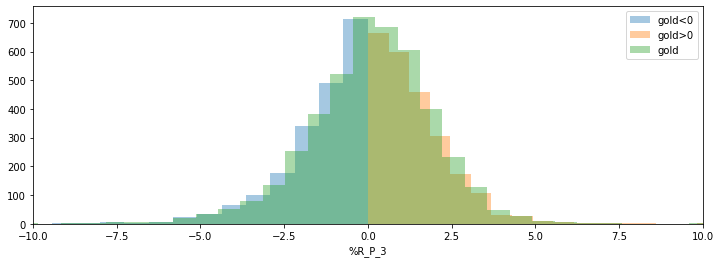

In [825]:
plt.figure(figsize=(12,4))
sns.distplot(a,kde=False,bins=20,label='gold<0',norm_hist=False)
sns.distplot(b,kde=False,bins=20,label='gold>0',norm_hist=False)
sns.distplot(c,kde=False,bins=40,label='gold',norm_hist=False)

plt.xlim(-10,10)
plt.legend()

In [826]:
a.count()+b.count(),c.count()

(4379, 4392)

In [833]:
Z.where(Z['Y_1_1.0']==2).dropna()

,0,1,2,3,4,5,6,7,8,9,...,Y_1_1.0,Y_2_1.0,Y_3_1.0,Y_4_1.0,Y_5_1.0,Y_1_1.5,Y_2_1.5,Y_3_1.5,Y_4_1.5,Y_5_1.5
75,4.731217,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
76,-0.832997,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
83,-0.257273,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0
99,0.003947,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
123,0.570324,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,0.425196,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-2.072842,-2.050116,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2082,4.223025,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-2.072842,-2.050116,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2083,-2.626759,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-2.072842,-2.050116,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2089,2.446418,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-6.430805,-6.366077,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [840]:
Z[(Z['Y_1_1.0']==2) & (Z['Y_1_1.5']==2)]

,0,1,2,3,4,5,6,7,8,9,...,Y_1_1.0,Y_2_1.0,Y_3_1.0,Y_4_1.0,Y_5_1.0,Y_1_1.5,Y_2_1.5,Y_3_1.5,Y_4_1.5,Y_5_1.5
76,-0.832997,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2,2,2,2,2,2,2,2,2,2
83,-0.257273,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2,2,2,2,2,2,1,2,2,2
99,0.003947,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2,1,1,1,1,2,1,1,1,1
123,0.570324,0.087834,0.088032,0.088230,0.088429,0.088627,0.088825,0.089023,0.089221,0.089419,...,2,1,1,1,1,2,1,1,1,1
254,1.139388,-0.811799,-0.811534,-0.811270,-0.811005,-0.810740,-0.810476,-0.810211,-0.809947,-4.406089,...,2,2,2,1,1,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080,0.425196,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-2.072842,-2.050116,...,2,2,2,2,2,2,2,2,2,2
2082,4.223025,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-2.072842,-2.050116,...,2,2,2,2,2,2,2,2,2,2
2083,-2.626759,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-2.072842,-2.050116,...,2,2,2,2,2,2,2,2,2,2
2089,2.446418,-2.229563,-2.226427,-2.223302,-2.196031,-2.169623,-2.132088,-2.096233,-6.430805,-6.366077,...,2,2,2,2,2,2,2,2,2,2


In [837]:
Z[0]

0      -0.724006
1       0.362245
2       0.178728
3       0.519380
4       0.364047
          ...   
2089    2.446418
2090    0.500765
2091   -4.350902
2092   -2.191794
2093    2.454123
Name: 0, Length: 13774, dtype: float64

In [838]:
Z['Y_1_1.0']==2

0       False
1       False
2       False
3       False
4       False
        ...  
2089     True
2090     True
2091    False
2092    False
2093    False
Name: Y_1_1.0, Length: 13774, dtype: bool